<a href="https://colab.research.google.com/github/jinoh5/disentangled/blob/main/regularization_included.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %cd /content/drive/MyDrive/Ramon Lab

/content/drive/MyDrive/Ramon Lab


## INPUT

In [ ]:
import scipy
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Hyperparameters
sigma = 1
N = 20
T = 100
numCond = 4
noise_var = 2

(400, 20)
(400, 20)


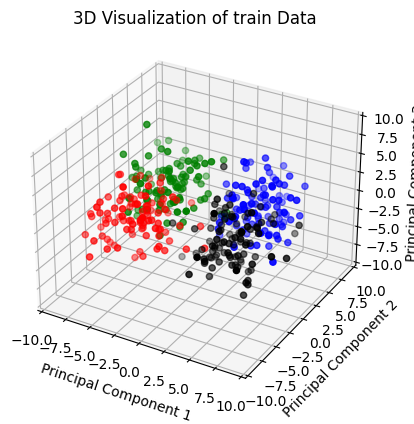

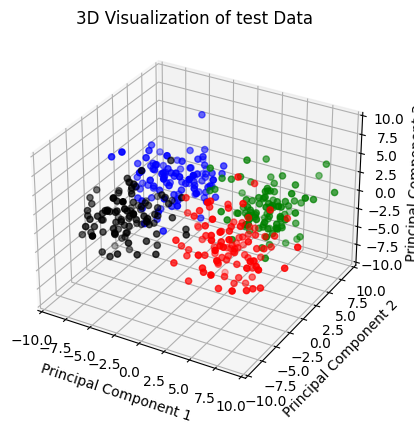

In [ ]:
# original condition
org_cond = np.zeros((4,2))
org_cond[1,:] = [1,0]
org_cond[2,:] = [1,1]
org_cond[3,:] = [0,1]

def create_input(sigma, N, T, numCond, noise_var, train_test):
  # ACTUAL INPUT
  cond = np.zeros((4,2))
  cond[0,:] = [1,1]
  cond[1,:] = [-1,1]
  cond[2,:] = [-1,-1]
  cond[3,:] = [1,-1]

  cond = cond.T
  subInput = np.zeros((numCond, N))

  W = scipy.stats.norm.rvs(loc=0, scale=sigma, size=[N,2])
  subInput[0,:] = W @ cond[:,0] # = np.matmul()
  subInput[1,:] = W @ cond[:,1]
  subInput[2,:] = W @ cond[:,2]
  subInput[3,:] = W @ cond[:,3]

  # Add noise
  input = np.zeros((numCond,T,N))
  # Project 'the square' to the N-dimensional space
  W = stats.norm.rvs(loc=0, scale=sigma, size=[N,2]) # this should go below
  for i in range(T): # T = 100 trials
      input[0,i,:] = W @ cond[:,0] # V (N x 1) = W (N x 2) * I (2 x 1)
      input[1,i,:] = W @ cond[:,1]
      input[2,i,:] = W @ cond[:,2]
      input[3,i,:] = W @ cond[:,3]

  # add very small Gaussian noise
  noise_matrix = np.random.normal(loc=0, scale=noise_var, size=input.shape)
  input_w_noise = input + noise_matrix

  # reshape
  input_dis = np.vstack((input_w_noise[0,:,:], input_w_noise[1,:,:], input_w_noise[2,:,:], input_w_noise[3,:,:]))

  # PCA
  pca = PCA(n_components = 3)
  transformed_data = pca.fit_transform(input_dis)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Scatter plot the transformed data
  for _, (idx, color) in enumerate(zip(range(4), ['r','g','b','k'])):
      ax.scatter(transformed_data[idx*100:(idx+1)*100, 0],
                transformed_data[idx*100:(idx+1)*100, 1],
                transformed_data[idx*100:(idx+1)*100, 2],
                c=color, marker='o')

  # Set labels and title
  ax.set_xlabel('Principal Component 1')
  ax.set_ylabel('Principal Component 2')
  ax.set_zlabel('Principal Component 3')
  ax.set_title('3D Visualization of ' + str(train_test) + ' Data')
  ax.set_xlim([-10, 10])
  ax.set_ylim([-10, 10])
  ax.set_zlim([-10, 10])

  return input_dis

train_input = create_input(sigma, N, T, numCond, noise_var, 'train')
print(train_input.shape)
test_input = create_input(sigma, N, T, numCond, noise_var, 'test')
print(test_input.shape)

## Build Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset

In [ ]:
# Experiment conditions
task1 = org_cond[:,0]
task2 = org_cond[:,1]
xor = np.sum(org_cond,axis=1)%2

In [ ]:
# Model 1 (nonlinear classifier)
class Simple_Nonlin(nn.Module):

  def __init__(self, input_dim, hidden_dim, output_dim):
    super(Simple_Nonlin, self).__init__()

    self.input_layer = nn.Linear(input_dim, hidden_dim)
    self.hidden_layer = nn.Linear(hidden_dim, output_dim) # here, I can add noise to make noises in the hidden layer

  def forward(self, x):

    x_h = F.relu(self.input_layer(x)) # Applying ReLU activation after input_layer
    output = self.hidden_layer(x_h)

    return x_h, output

In [ ]:
# Hyperparameters
exp_cond = xor
n_trials_perpoint = 100
input = train_input
input_dim = 20
output_dim = 2
batchsize = 20
learning_rate = 0.001

In [ ]:
# Experiment target
target = np.repeat(exp_cond, n_trials_perpoint)

input_tensor = torch.tensor(input, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.long)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(input_tensor, target_tensor)

# Define the size of train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create train and test dataloaders
train_loader = DataLoader(train_dataset, batch_size = batchsize, shuffle=True) # shuffle the training dataset every time it starts a new epoch
test_loader = DataLoader(test_dataset, batch_size = batchsize, shuffle=False)

# hidden dim
hidden_dim = input_dim * 2

# Create an instance of a model
model = Simple_Nonlin(input_dim, hidden_dim, output_dim) # so that you can only input 'model' not 'modelName'
print(model)

# optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # this is where I will add regularization metrics

Simple_Nonlin(
  (input_layer): Linear(in_features=20, out_features=40, bias=True)
  (hidden_layer): Linear(in_features=40, out_features=2, bias=True)
)


In [ ]:
def custom_loss(output, targets, sparsity, beta1, beta2):
  '''
  Custom loss function
  '''
  criterion = nn.CrossEntropyLoss() # you must instantiate the loss
  crossEntropyLoss = criterion(output, targets)
  totalLoss = beta1 * criterion(output, targets) + beta2 * sparsity

  return crossEntropyLoss, totalLoss

def L1_norm(hidden_output):
  l1_norm = torch.sum(torch.abs(hidden_output)) # gives me a simple number
  return l1_norm

In [ ]:
# Hyperparameters
expname = "XOR"
regularization_model = L1_norm
num_epochs = 70
beta1 = 1
beta2 = 0.0001

Epoch [1/70], Training Loss: 0.7236, Validation Loss: 0.6516
Epoch [2/70], Training Loss: 0.6547, Validation Loss: 0.6118
Epoch [3/70], Training Loss: 0.6011, Validation Loss: 0.5642
Epoch [4/70], Training Loss: 0.5531, Validation Loss: 0.5253
Epoch [5/70], Training Loss: 0.5070, Validation Loss: 0.4827
Epoch [6/70], Training Loss: 0.4639, Validation Loss: 0.4384
Epoch [7/70], Training Loss: 0.4220, Validation Loss: 0.4056
Epoch [8/70], Training Loss: 0.3860, Validation Loss: 0.3680
Epoch [9/70], Training Loss: 0.3522, Validation Loss: 0.3446
Epoch [10/70], Training Loss: 0.3235, Validation Loss: 0.3176
Epoch [11/70], Training Loss: 0.2994, Validation Loss: 0.2977
Epoch [12/70], Training Loss: 0.2791, Validation Loss: 0.2812
Epoch [13/70], Training Loss: 0.2620, Validation Loss: 0.2683
Epoch [14/70], Training Loss: 0.2472, Validation Loss: 0.2609
Epoch [15/70], Training Loss: 0.2343, Validation Loss: 0.2523
Epoch [16/70], Training Loss: 0.2234, Validation Loss: 0.2441
Epoch [17/70], Tr

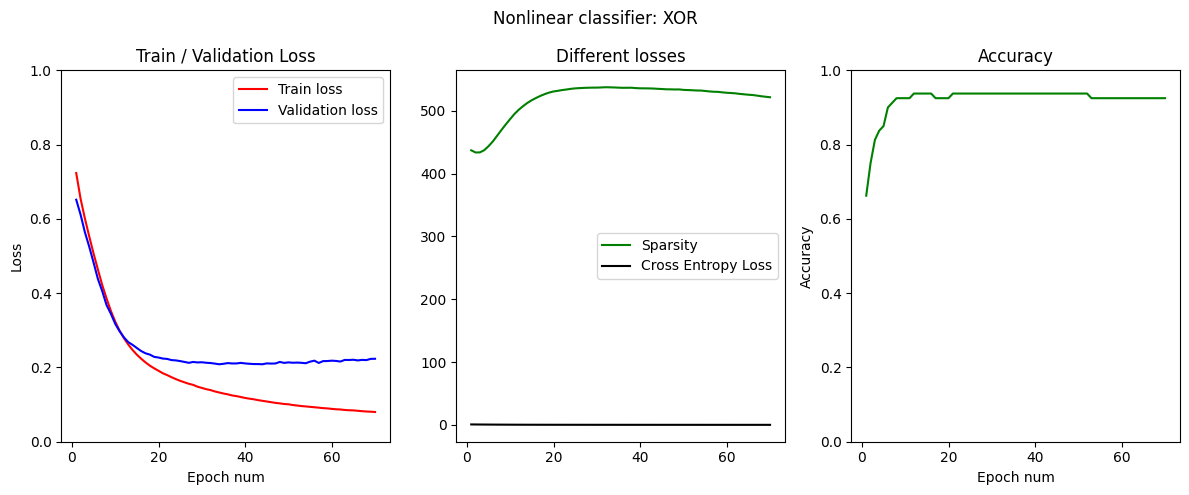

In [ ]:
# Training loop
trainLosses = []
valLosses = []
accuracies = []
sparsities = []
crossEntropyLosses = []

for epoch in range(num_epochs): # for every epoch

  # train set up
  model.train()
  train_loss = 0 # for every epoch, the loss is added across all batches
  sparsity_loss = 0
  crossEntropy_loss = 0

  for inputs, targets in train_loader: # During each epoch's training loop, when you iterate through 'train loader'
                                      # the batches ('inputs' and 'targets') are provided in a shuffled order.
                                      # this means that the order of data samples within each batch is randomized compared to the previous epoch

    inputs = inputs.float()

    # clear the gradients
    optimizer.zero_grad()

    # Apply the model
    x_h, output = model(inputs)

    # Compute sparsity from the hidden layer
    sparsity = regularization_model(x_h)
    sparsity_loss += sparsity

    # Compute the loss
    crossEntropyLoss, loss = custom_loss(output, targets, sparsity, beta1, beta2)
    crossEntropy_loss += crossEntropyLoss

    # Backpropagation
    loss.backward()

    # Update the weights
    optimizer.step()

    # Add loss
    train_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)
  trainLosses.append(avg_train_loss)

  avg_sparsity = sparsity_loss / len(train_loader)
  sparsities.append(avg_sparsity)

  avg_crossEntropy_loss = crossEntropy_loss/len(train_loader)
  crossEntropyLosses.append(avg_crossEntropy_loss)

  # Evaluation phase

  model.eval()
  val_loss = 0
  total = 0
  correct = 0

  with torch.no_grad(): # no need to track gradients during evaluation

    for inputs, targets in test_loader:

      # test input
      test_x_h, testoutput = model(inputs)

      # Compute sparsity from the hidden layer
      sparsity = regularization_model(test_x_h)

      # Compute the loss
      crossEntropyLoss, loss = custom_loss(testoutput, targets, sparsity, beta1, beta2)

      # find the validation loss
      val_loss += loss.item()

      # Get the max output?
      _, predicted = torch.max(testoutput, 1)

      # print("targets", targets)
      # print("predicted", predicted)

      # store the result
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

    accuracy = correct / total
    accuracies.append(accuracy)

  # Average validation loss for this epoch
  avg_val_loss = val_loss / len(test_loader)
  valLosses.append(avg_val_loss)

  if (epoch+1) % 1 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(test_loader):.4f}')


sparsities_list = [tensor.detach().numpy() for tensor in sparsities]
crossEntropyLosses_list = [tensor.detach().numpy() for tensor in crossEntropyLosses]

# Plot train loss and validation loss and accuracy
epoch_nums = np.arange(num_epochs)+1

fig, axs = plt.subplots(1,3, figsize=(12,5))

axs[0].plot(epoch_nums, trainLosses, 'r')
axs[0].plot(epoch_nums, valLosses, 'b')
axs[0].set_title("Train / Validation Loss")
axs[0].set_xlabel("Epoch num")
axs[0].set_ylabel("Loss")
axs[0].legend(['Train loss', 'Validation loss'])
axs[0].set_ylim([0, 1])

axs[1].plot(epoch_nums, sparsities_list, 'g')
axs[1].plot(epoch_nums, crossEntropyLosses_list, 'k')
axs[1].legend(['Sparsity', 'Cross Entropy Loss'])
axs[1].set_title("Different losses")

axs[2].plot(epoch_nums, accuracies, 'g')
axs[2].set_title("Accuracy")
axs[2].set_xlabel("Epoch num")
axs[2].set_ylabel("Accuracy")
axs[2].set_ylim([0, 1])

plt.suptitle("Nonlinear classifier: " + str(expname))
plt.tight_layout()
plt.show()


## PCA on the output of the hidden layer

In [ ]:
test_input_tensor = torch.tensor(test_input, dtype=torch.float32)

# evaluation mode
model.eval()

with torch.no_grad():
  new_x_h, output = model(test_input_tensor)

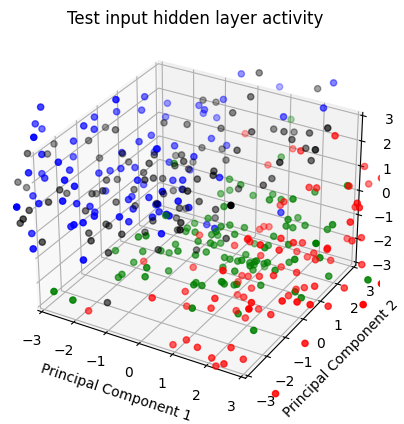

In [ ]:
# new_x_h = new_x_h.detach().numpy()
pca = PCA(n_components = 3)
transformed_Xh = pca.fit_transform(new_x_h)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the transformed data
for _, (idx, color) in enumerate(zip(range(4), ['r','g','b','k'])):
    ax.scatter(transformed_Xh[idx*100:(idx+1)*100, 0],
               transformed_Xh[idx*100:(idx+1)*100, 1],
               transformed_Xh[idx*100:(idx+1)*100, 2],
               c=color, marker='o')


# Set labels and title (axis is important)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Test input hidden layer activity')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([-3, 3])

plt.show()

## Calculate the centroid and find the distances between the points

In [ ]:
def calculate_centroid(points):
    x_coords = points[:, 0]
    y_coords = points[:, 1]
    z_coords = points[:, 2]
    centroid_x = np.mean(x_coords)
    centroid_y = np.mean(y_coords)
    centroid_z = np.mean(z_coords)

    return [centroid_x, centroid_y, centroid_z]

def find_euclidean_distance(onepoint, otherpoint):
    d = np.sqrt((onepoint[0] - otherpoint[0])**2 +
                (onepoint[1] - otherpoint[1])**2 +
                (onepoint[2] - otherpoint[2])**2)
    return d

                                        one,           two,               three
Distances from the point 0 (red dots) [1.8495253388700508, 2.269045233978464, 1.6264898829012566]
                                        two,               three
Distances from the point 1 (green dots) [2.1641609107033357, 1.7248098376944514]
Distance from the point 2 to point 3) 3.4121351467117758


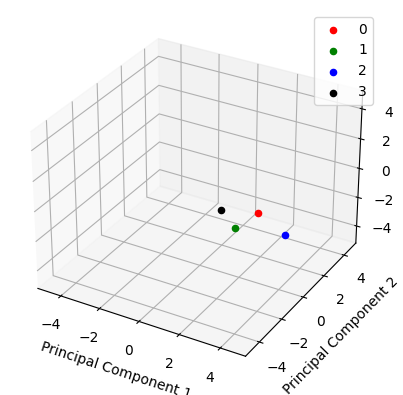

In [ ]:
# calculate the centroid
total_centroid = np.zeros((4,3))
for i in range(len(trialNum)-1):
  total_centroid[i,:] = calculate_centroid(transformed_Xh[i:i+1,:])

# Plot the centroid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for _, (idx, color) in enumerate(zip(range(4), ['r','g','b','k'])):
    ax.scatter(total_centroid[idx:idx+1, 0],
               total_centroid[idx:idx+1, 1],
               total_centroid[idx:idx+1, 2],
               c=color, marker='o')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([-5, 5])
ax.legend([0,1,2,3], loc=1)

# calculate the distance
distances = []
for i in range(3):
    distances.append(find_euclidean_distance(total_centroid[0,:], total_centroid[i+1,:]))

print("                                        one,           two,               three")
print("Distances from the point 0 (red dots)", distances)

distances_2 = []
for i in [2,3]:
    distances_2.append(find_euclidean_distance(total_centroid[1,:], total_centroid[i,:]))

print("                                        two,               three")

print("Distances from the point 1 (green dots)", distances_2)


print("Distance from the point 2 to point 3)", find_euclidean_distance(total_centroid[2,:], total_centroid[3,:]))

In [ ]:
#